In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import os
import shutil

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter

from utils.show_grid import show_grid
from utils.augment import CutMix
from train import train_model
from utils.freeze import freezeParams, unfreezeParams, count_parameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [3]:
EPOCHS = 5

In [4]:
BASE_LOG_DIR = os.path.join(os.getcwd(), "tboard_logs")

os.makedirs(BASE_LOG_DIR, exist_ok=True)

## Augmentations

In [5]:
from dataset import PersonRobotDataset

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# the value for the split are found manually to have 150 pictures of each class in training
dataset = PersonRobotDataset("data/images", train_ratio=.837, train_transform=data_transforms['train'], val_transform=data_transforms['val'])

cutmix_transform = CutMix()
train_loader = dataset.train_dataloader(collate_fn=cutmix_transform)
val_loader = dataset.val_dataloader()

Training set size: 300 images
Validation set size: 60 images


/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


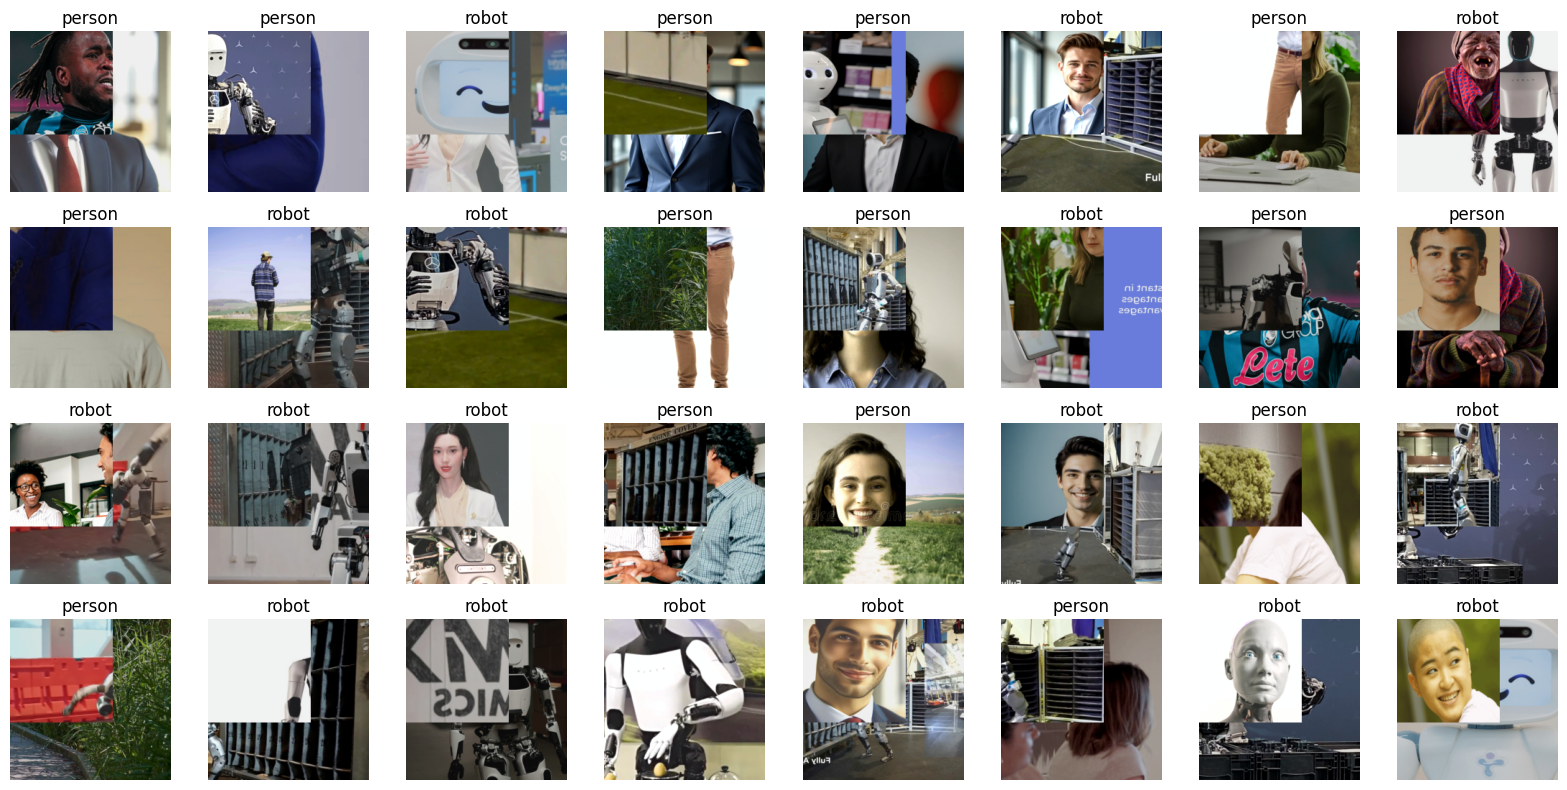

In [6]:
class_names = dataset.train_dataset.dataset.classes
inputs, classes = next(iter(train_loader))
titles = [class_names[1-int(x <= 0.5)] for x in classes]        
show_grid(inputs, titles)

## Training

In [7]:
from utils.seed import set_random_seed

set_random_seed()

### ResNet

In [8]:
resnet_model = models.resnet18(pretrained=True)
resnet_model.fc = nn.Sequential(
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256, 1)
)
resnet_model.to(device)

/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [20]:
TBOARD_LOGS = os.path.join(BASE_LOG_DIR, "ResNet_tuned2")
os.makedirs(TBOARD_LOGS, exist_ok=True)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [ ]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=resnet_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=2*EPOCHS, device=device, logger=writer.add_scalar
    )

  0%|          | 0/10 [00:00<?, ?it/s]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 10%|█         | 1/10 [00:02<00:19,  2.18s/it]

Epoch 1/10
    Train loss: 0.41388
    Valid loss: 0.0742
    Accuracy: 100.0%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██        | 2/10 [00:04<00:17,  2.21s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 30%|███       | 3/10 [00:06<00:15,  2.23s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: 

Epoch 6/10
    Train loss: 0.35884
    Valid loss: 0.07479
    Accuracy: 100.0%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 70%|███████   | 7/10 [00:15<00:06,  2.20s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 80%|████████  | 8/10 [00:17<00:04,  2.17s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: 

Epoch 10/10
    Train loss: 0.37252
    Valid loss: 0.07487
    Accuracy: 100.0%


Training completed


### ConvNext

In [22]:
TBOARD_LOGS = os.path.join(BASE_LOG_DIR, "ConvNext_tuned")
os.makedirs(TBOARD_LOGS, exist_ok=True)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [23]:
convnext_model = models.convnext_tiny(pretrained=True)
num_ftrs = convnext_model.classifier[2].in_features
convnext_model.classifier[2] = nn.Linear(num_ftrs, 1)
convnext_model.to(device)
print(convnext_model.classifier)

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=1, bias=True)
)


In [24]:
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convnext_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [ ]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=convnext_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=2*EPOCHS, device=device, logger=writer.add_scalar
    )

  0%|          | 0/10 [00:00<?, ?it/s]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 10%|█         | 1/10 [00:02<00:23,  2.61s/it]

Epoch 1/10
    Train loss: 0.51842
    Valid loss: 0.78622
    Accuracy: 35.0%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██        | 2/10 [00:05<00:20,  2.62s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 30%|███       | 3/10 [00:07<00:18,  2.65s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: 

Epoch 6/10
    Train loss: 0.22134
    Valid loss: 0.04906
    Accuracy: 98.33333333333333%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 70%|███████   | 7/10 [00:18<00:08,  2.74s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 80%|████████  | 8/10 [00:21<00:05,  2.65s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 90%|█████████ | 9/10 [00:23<00:02,  2.62s/it]/home/user/kellerv1/miniforge3/envs/lab/li

Epoch 10/10
    Train loss: 0.28901
    Valid loss: 0.05141
    Accuracy: 98.33333333333333%


Training completed


### EfficientNet

In [26]:
TBOARD_LOGS = os.path.join(BASE_LOG_DIR, "EfficientNet_tuned")
os.makedirs(TBOARD_LOGS, exist_ok=True)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [27]:
efficient_model = models.efficientnet_b0(pretrained=True)
num_ftrs = efficient_model.classifier[1].in_features
efficient_model.classifier[1] = nn.Linear(num_ftrs, 1)
efficient_model.to(device)
print(efficient_model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1, bias=True)
)


In [28]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(efficient_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [ ]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=efficient_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=2*EPOCHS, device=device, logger=writer.add_scalar
    )

  0%|          | 0/10 [00:00<?, ?it/s]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 10%|█         | 1/10 [00:02<00:22,  2.49s/it]

Epoch 1/10
    Train loss: 0.64619
    Valid loss: 0.72255
    Accuracy: 38.333333333333336%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██        | 2/10 [00:05<00:20,  2.52s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 30%|███       | 3/10 [00:07<00:17,  2.49s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: 

Epoch 6/10
    Train loss: 0.40818
    Valid loss: 0.11564
    Accuracy: 100.0%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 70%|███████   | 7/10 [00:16<00:06,  2.29s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 80%|████████  | 8/10 [00:18<00:04,  2.35s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: 

Epoch 10/10
    Train loss: 0.35061
    Valid loss: 0.10428
    Accuracy: 100.0%


Training completed


## Models as a fixed feature extractor

### ResNet

In [53]:
resnet_model = models.resnet18(pretrained=True)
freezeParams(resnet_model)

resnet_model.fc = nn.Sequential(
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256, 1)
)
resnet_model.to(device)

count_parameters(resnet_model)

Total parameters: 11,308,097, trainable: 131,585


In [54]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [55]:
TBOARD_LOGS = os.path.join(BASE_LOG_DIR, "ResNet_fixed")
os.makedirs(TBOARD_LOGS, exist_ok=True)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [56]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=resnet_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=2*EPOCHS, device=device, logger=writer.add_scalar
    )

  0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 10%|███████████                                                                                                    | 1/10 [00:02<00:21,  2.37s/it]

Epoch 1/10
    Train loss: 0.65787
    Valid loss: 0.65548
    Accuracy: 58.333333333333336%




/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██████████████████████▏                                                                                        | 2/10 [00:04<00:19,  2.42s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 30%|█████████████████████████████████▎                                                                             | 3/10 [00:07<00:18,  2.65s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Pa

Epoch 6/10
    Train loss: 0.46464
    Valid loss: 0.2776
    Accuracy: 95.0%




/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:18<00:07,  2.61s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [00:20<00:05,  2.61s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Pa

Epoch 10/10
    Train loss: 0.42357
    Valid loss: 0.23381
    Accuracy: 95.0%


Training completed


### ConvNext

In [52]:
TBOARD_LOGS = os.path.join(BASE_LOG_DIR, "ConvNext_fixed")
os.makedirs(TBOARD_LOGS, exist_ok=True)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [53]:
convnext_model = models.convnext_tiny(pretrained=True)
freezeParams(convnext_model)
num_ftrs = convnext_model.classifier[2].in_features
convnext_model.classifier[2] = nn.Linear(num_ftrs, 1)
convnext_model.to(device)

count_parameters(convnext_model)

/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total parameters: 27,820,897, trainable: 769


In [54]:
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convnext_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [55]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=convnext_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=2*EPOCHS, device=device, logger=writer.add_scalar
    )

  0%|          | 0/10 [00:00<?, ?it/s]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 10%|█         | 1/10 [00:02<00:20,  2.33s/it]

Epoch 1/10
    Train loss: 0.74285
    Valid loss: 0.7945
    Accuracy: 45.0%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██        | 2/10 [00:04<00:18,  2.33s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 30%|███       | 3/10 [00:06<00:16,  2.33s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: 

Epoch 6/10
    Train loss: 0.64018
    Valid loss: 0.58921
    Accuracy: 80.0%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 70%|███████   | 7/10 [00:16<00:07,  2.46s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 80%|████████  | 8/10 [00:19<00:04,  2.39s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: 

Epoch 10/10
    Train loss: 0.62216
    Valid loss: 0.55084
    Accuracy: 86.66666666666667%


Training completed


### EfficientNet

In [56]:
TBOARD_LOGS = os.path.join(BASE_LOG_DIR, "EfficientNet_fixed")
os.makedirs(TBOARD_LOGS, exist_ok=True)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [57]:
efficient_model = models.efficientnet_b0(pretrained=True)
freezeParams(efficient_model)

num_ftrs = efficient_model.classifier[1].in_features
efficient_model.classifier[1] = nn.Linear(num_ftrs, 1)
efficient_model.to(device)

count_parameters(efficient_model)

/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total parameters: 4,008,829, trainable: 1,281


In [58]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(efficient_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [59]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=efficient_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=2*EPOCHS, device=device, logger=writer.add_scalar
    )

  0%|          | 0/10 [00:00<?, ?it/s]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 10%|█         | 1/10 [00:02<00:20,  2.28s/it]

Epoch 1/10
    Train loss: 0.67915
    Valid loss: 0.69419
    Accuracy: 53.333333333333336%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██        | 2/10 [00:04<00:18,  2.30s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 30%|███       | 3/10 [00:07<00:16,  2.36s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: 

Epoch 6/10
    Train loss: 0.64949
    Valid loss: 0.59485
    Accuracy: 88.33333333333333%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 70%|███████   | 7/10 [00:15<00:06,  2.15s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 80%|████████  | 8/10 [00:17<00:04,  2.18s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 90%|█████████ | 9/10 [00:20<00:02,  2.22s/it]/home/user/kellerv1/miniforge3/envs/lab/li

Epoch 10/10
    Train loss: 0.64525
    Valid loss: 0.57419
    Accuracy: 91.66666666666666%


Training completed


## Models with a Combined Approach

### ResNet

In [9]:
resnet_model = models.resnet18(pretrained=True)
freezeParams(resnet_model)

resnet_model.fc = nn.Sequential(
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256, 1)
)
resnet_model.to(device)

count_parameters(resnet_model)

/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total parameters: 11,308,097, trainable: 131,585


In [10]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [11]:
TBOARD_LOGS = os.path.join(BASE_LOG_DIR, "ResNet_tuned_combined")
os.makedirs(TBOARD_LOGS, exist_ok=True)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [14]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=resnet_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=EPOCHS, device=device, logger=writer.add_scalar
    )

  0%|                                                                                                                        | 0/5 [00:00<?, ?it/s]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██████████████████████▍                                                                                         | 1/5 [00:03<00:14,  3.59s/it]

Epoch 1/5
    Train loss: 0.66542
    Valid loss: 0.71904
    Accuracy: 46.666666666666664%




/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 40%|████████████████████████████████████████████▊                                                                   | 2/5 [00:06<00:09,  3.06s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 60%|███████████████████████████████████████████████████████████████████▏                                            | 3/5 [00:09<00:05,  2.94s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Pa

Epoch 5/5
    Train loss: 0.4557
    Valid loss: 0.3323
    Accuracy: 95.0%


Training completed


In [15]:
unfreezeParams(resnet_model)

In [16]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=resnet_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=EPOCHS, device=device, logger=writer.add_scalar,
        start_epoch=EPOCHS
    )

  0%|                                                                                                                        | 0/5 [00:00<?, ?it/s]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██████████████████████▍                                                                                         | 1/5 [00:02<00:09,  2.32s/it]

Epoch 1/5
    Train loss: 0.45203
    Valid loss: 0.27888
    Accuracy: 95.0%




/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 40%|████████████████████████████████████████████▊                                                                   | 2/5 [00:04<00:06,  2.31s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 60%|████████████████████████████████████████

Epoch 5/5
    Train loss: 0.37211
    Valid loss: 0.1292
    Accuracy: 96.66666666666667%


Training completed


### ConvNext

In [47]:
convnext_model = models.convnext_tiny(pretrained=True)
freezeParams(convnext_model)
num_ftrs = convnext_model.classifier[2].in_features
convnext_model.classifier[2] = nn.Linear(num_ftrs, 1)
convnext_model.to(device)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [48]:
TBOARD_LOGS = os.path.join(BASE_LOG_DIR, "ConvNext_tuned_combined")
os.makedirs(TBOARD_LOGS, exist_ok=True)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [49]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(convnext_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [50]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=convnext_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=EPOCHS, device=device, logger=writer.add_scalar
    )

  0%|                                                                                                                        | 0/5 [00:00<?, ?it/s]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██████████████████████▍                                                                                         | 1/5 [00:02<00:09,  2.40s/it]

Epoch 1/5
    Train loss: 0.75431
    Valid loss: 0.81816
    Accuracy: 38.333333333333336%




/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 40%|████████████████████████████████████████████▊                                                                   | 2/5 [00:04<00:07,  2.42s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 60%|███████████████████████████████████████████████████████████████████▏                                            | 3/5 [00:07<00:04,  2.49s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Pa

Epoch 5/5
    Train loss: 0.66207
    Valid loss: 0.64394
    Accuracy: 65.0%


Training completed


In [51]:
unfreezeParams(convnext_model)

In [52]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=convnext_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=EPOCHS, device=device, logger=writer.add_scalar,
        start_epoch=EPOCHS
    )

  0%|                                                                                                                        | 0/5 [00:00<?, ?it/s]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██████████████████████▍                                                                                         | 1/5 [00:02<00:11,  2.88s/it]

Epoch 1/5
    Train loss: 0.57156
    Valid loss: 0.60828
    Accuracy: 73.33333333333333%




/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 40%|████████████████████████████████████████████▊                                                                   | 2/5 [00:05<00:08,  2.99s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 60%|███████████████████████████████████████████████████████████████████▏                                            | 3/5 [00:08<00:05,  2.96s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Pa

Epoch 5/5
    Train loss: 0.37611
    Valid loss: 0.09899
    Accuracy: 100.0%


Training completed


### EfficientNet

In [41]:
efficient_model = models.efficientnet_b0(pretrained=True)

freezeParams(efficient_model)

num_ftrs = efficient_model.classifier[1].in_features
efficient_model.classifier[1] = nn.Linear(num_ftrs, 1)
efficient_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [42]:
TBOARD_LOGS = os.path.join(BASE_LOG_DIR, "EfficientNet_tuned_combined")
os.makedirs(TBOARD_LOGS, exist_ok=True)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [43]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(efficient_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [44]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=efficient_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=EPOCHS, device=device, logger=writer.add_scalar
    )

  0%|                                                                                                                        | 0/5 [00:00<?, ?it/s]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██████████████████████▍                                                                                         | 1/5 [00:02<00:10,  2.55s/it]

Epoch 1/5
    Train loss: 0.68317
    Valid loss: 0.7711
    Accuracy: 30.0%




/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 40%|████████████████████████████████████████████▊                                                                   | 2/5 [00:04<00:07,  2.39s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 60%|████████████████████████████████████████

Epoch 5/5
    Train loss: 0.63524
    Valid loss: 0.61034
    Accuracy: 85.0%


Training completed


In [45]:
unfreezeParams(efficient_model)

In [46]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=efficient_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=EPOCHS, device=device, logger=writer.add_scalar,
        start_epoch=EPOCHS
    )

  0%|                                                                                                                        | 0/5 [00:00<?, ?it/s]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██████████████████████▍                                                                                         | 1/5 [00:02<00:10,  2.56s/it]

Epoch 1/5
    Train loss: 0.6394
    Valid loss: 0.59358
    Accuracy: 88.33333333333333%




/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 40%|████████████████████████████████████████████▊                                                                   | 2/5 [00:05<00:07,  2.56s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 60%|███████████████████████████████████████████████████████████████████▏                                            | 3/5 [00:07<00:05,  2.62s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 80%|█████████████████████████████████████████████████████████████████████████████████████████▌     

Epoch 5/5
    Train loss: 0.50454
    Valid loss: 0.35344
    Accuracy: 98.33333333333333%


Training completed


To compare the performance of EfficientNet models, we analyzed TensorBoard logs from the experiments EfficientNet_fixed and EfficientNet_tuned_combined, focusing on validation accuracy over training epochs.

The EfficientNet_tuned_combined model shows a slower start but eventually outperforms the fixed-feature model by a significant margin, reaching 98.33% accuracy compared to 91.67% for EfficientNet_fixed. This indicates that full fine-tuning combined with additional training adaptations enables the model to better capture task-specific features and improve generalization.

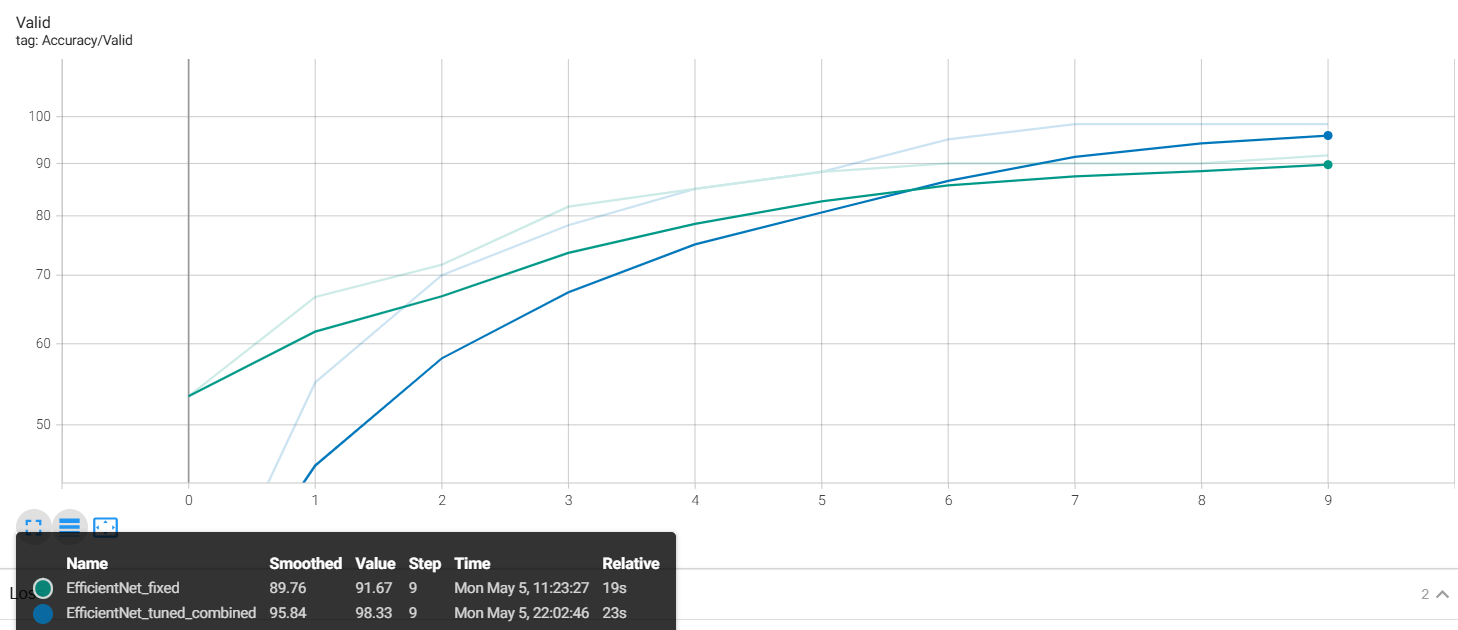

### DINOv2-based model used as a fixed feature extractor

In [12]:
import timm
from timm.models.vision_transformer import _create_vision_transformer, VisionTransformer
from timm.models.layers import SelectAdaptivePool2d
from functools import partial

model_kwargs = dict(
        patch_size=14,
        embed_dim=384,
        depth=12,
        num_heads=6,
        mlp_ratio=4,
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        num_classes=0,
        img_size=224,  # default was 518
    )

dinov2 = timm.create_model(
            "vit_small_patch14_dinov2.lvd142m",
            pretrained=True,
            **model_kwargs
        )

/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [59]:
for param in dinov2.parameters():
    param.requires_grad = False

num_logits = dinov2.norm.normalized_shape[0]

dinov2.head = nn.Sequential(
    nn.Linear(num_logits, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 1)
)

dinov2 = dinov2.to(device)

In [60]:
TBOARD_LOGS = os.path.join(BASE_LOG_DIR, "DINOv2_fixed")
os.makedirs(TBOARD_LOGS, exist_ok=True)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [61]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(dinov2.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [62]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=dinov2, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=2*EPOCHS, device=device, logger=writer.add_scalar
    )

  0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 10%|███████████                                                                                                    | 1/10 [00:02<00:23,  2.58s/it]

Epoch 1/10
    Train loss: 0.59927
    Valid loss: 0.71328
    Accuracy: 55.00000000000001%




/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██████████████████████▏                                                                                        | 2/10 [00:04<00:19,  2.46s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 30%|█████████████████████████████████▎                                                                             | 3/10 [00:07<00:16,  2.42s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Pa

Epoch 6/10
    Train loss: 0.41071
    Valid loss: 0.11113
    Accuracy: 100.0%




/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:17<00:07,  2.50s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 80%|████████████████████████████████████████

Epoch 10/10
    Train loss: 0.35383
    Valid loss: 0.1057
    Accuracy: 100.0%


Training completed


To assess the performance of a self-supervised DINOv2-based model compared to traditional CNN-based architectures, we used TensorBoard logs from the following fixed-feature extractor experiments:

- DINOv2_fixed
- ConvNeXt_fixed
- EfficientNet_fixed
- ResNet_fixed

All models were evaluated under identical training settings, and only the classification head was trained while feature extractors remained frozen. The graph above displays validation accuracy across 10 epochs.

The DINOv2_fixed model achieved the highest final validation accuracy of 100%, significantly outperforming the CNN-based alternatives:

- ConvNeXt_fixed: 86.67%

- EfficientNet_fixed: 91.67%

- ResNet_fixed: 95%

DINOv2 showed faster convergence and higher final performance, reaching over 90% accuracy by epoch 2. Such high accuracy of the model is probably due to the fact that we have a simple task (binary actually, because there are only 2 classes) and the model is complex so it can cope with it easily.

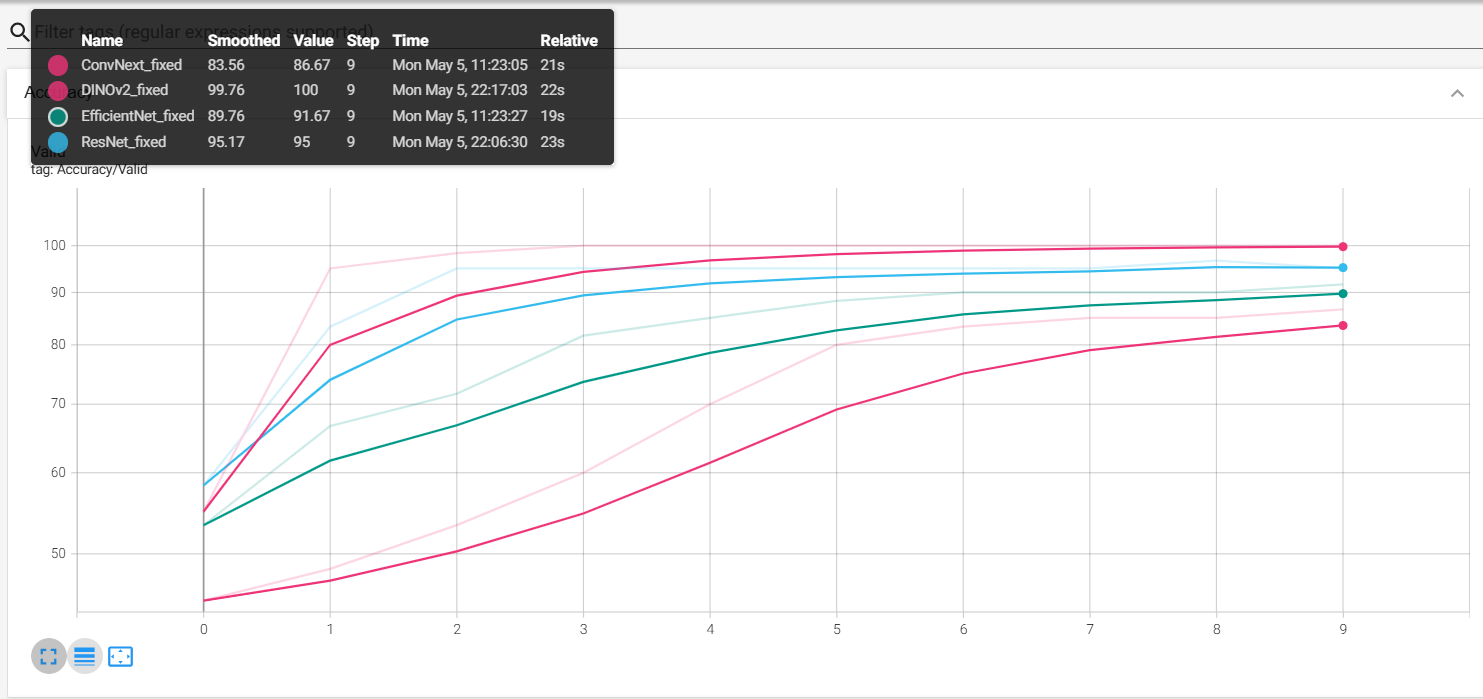

### Extra: SwinTransformer model

In [57]:
import torch.nn as nn

class Permute(nn.Module):
    def __init__(self, *dims):
        super().__init__()
        self.dims = dims
    def forward(self, x):
        return x.permute(*self.dims)

In [58]:
transformer_model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)

in_features = transformer_model.head.fc.in_features
transformer_model.head = nn.Sequential(
    Permute(0, 3, 1, 2),
    SelectAdaptivePool2d(pool_type='avg', flatten=True),
    nn.Dropout(p=0.0),
    nn.Linear(in_features, 1),
    nn.Identity() 
)
transformer_model.to(device)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

In [59]:
TBOARD_LOGS = os.path.join(BASE_LOG_DIR, "SwinTransformer_fixed")
os.makedirs(TBOARD_LOGS, exist_ok=True)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [60]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [61]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=transformer_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=2*EPOCHS, device=device, logger=writer.add_scalar
    )

  0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 10%|███████████                                                                                                    | 1/10 [00:04<00:39,  4.42s/it]

Epoch 1/10
    Train loss: 0.41328
    Valid loss: 0.56712
    Accuracy: 76.66666666666667%




/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██████████████████████▏                                                                                        | 2/10 [00:08<00:35,  4.45s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 30%|█████████████████████████████████▎      

Epoch 6/10
    Train loss: 0.29414
    Valid loss: 0.02978
    Accuracy: 100.0%




/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:31<00:13,  4.45s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [00:35<00:08,  4.41s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Pa

Epoch 10/10
    Train loss: 0.27785
    Valid loss: 0.01958
    Accuracy: 100.0%


Training completed


To evaluate the benefits of fine-tuning a Transformer-based model, we trained and compared SwinTransformer_fixed against CNN-based models (ConvNeXt_fixed, EfficientNet_fixed, and ResNet_fixed) using TensorBoard logs.

Among all models, SwinTransformer_fixed achieved the highest validation accuracy of 100%, outperforming all CNNs:

- ResNet_fixed: 95%

- EfficientNet_fixed: 91.67%

- ConvNeXt_fixed: 86.67%

Despite a longer training time (40s vs. ~20s), SwinTransformer maintained superior performance throughout. Such high accuracy of SwinTransformer_fixed model is probably due to the fact that we have too simple task for such complex model.

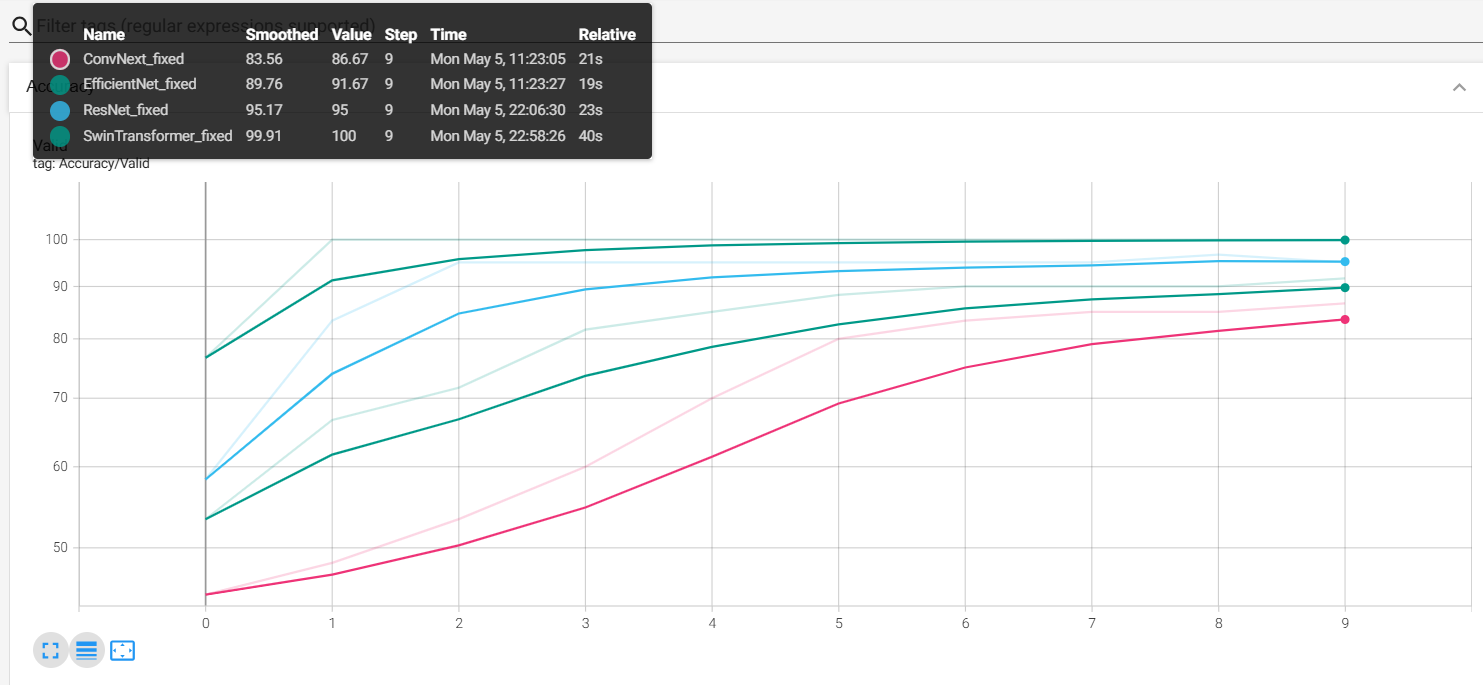